In [1]:
import pandas
import numpy
import matplotlib
import os
import seaborn as sns
import numpy as np
import sklearn
import torch
import torch.nn as nn
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
df_raw = pandas.read_csv('./data/italy/covid19_italy_region.csv',
                        usecols=["Date", "RegionName", "Latitude", "Longitude", 
                        "NewPositiveCases", "TotalPositiveCases", "Deaths",
                        "TotalHospitalizedPatients", "IntensiveCarePatients"],
                        parse_dates=["Date"])
df_raw['Date'] = df_raw['Date'].dt.date
df_raw.set_index(["Date"], inplace=True)
df_raw.head()

,RegionName,Latitude,Longitude,IntensiveCarePatients,TotalHospitalizedPatients,NewPositiveCases,Deaths,TotalPositiveCases
Date,,,,,,,,
2020-02-24,Abruzzo,42.351222,13.398438,0,0,0,0,0
2020-02-24,Basilicata,40.639471,15.805148,0,0,0,0,0
2020-02-24,Calabria,38.905976,16.594402,0,0,0,0,0
2020-02-24,Campania,40.839566,14.250850,0,0,0,0,0
2020-02-24,Emilia-Romagna,44.494367,11.341721,2,12,18,0,18


In [3]:
df_pop =  pandas.read_csv('./data/italy/region_population.csv', index_col=['Territory'])

In [4]:
lat_df = df_raw[["RegionName", "Latitude", "Longitude"]]
lat_df = lat_df.drop_duplicates().sort_values(['Latitude'], ascending=False)
regions = lat_df['RegionName'].to_numpy()
lat_df

,RegionName,Latitude,Longitude
Date,,,
2020-02-24,P.A. Bolzano,46.499335,11.356624
2020-02-24,P.A. Trento,46.068935,11.121231
2020-02-24,Valle d'Aosta,45.737503,7.320149
2020-02-24,Friuli Venezia Giulia,45.649435,13.768136
2020-02-24,Lombardia,45.466794,9.190347
2020-02-24,Veneto,45.434905,12.338452
2020-02-24,Piemonte,45.073274,7.680687
2020-02-24,Emilia-Romagna,44.494367,11.341721
2020-02-24,Liguria,44.411493,8.932699


In [5]:
df_for_regions = {}
for region in regions:
    regional_df = df_raw.loc[df_raw.RegionName == region].copy()
    regional_df.drop(['RegionName', 'Latitude', 'Longitude'], axis=1, inplace=True)
    regional_df = regional_df.sort_values('Date')
    regional_df[['NewPositiveCaseDensity', 'DeathDensity', 'TotalPositiveCaseDensity']] = regional_df[["NewPositiveCases", "Deaths", "TotalPositiveCases"]] * 10000/df_pop.Value[region]
    regional_df[regional_df < 0] = 0
    regional_df = regional_df.iloc[0:150]
    regional_df = (regional_df-regional_df.min())/(regional_df.max()-regional_df.min())
    df_for_regions[region] = regional_df
df_for_regions['Abruzzo'].shape

(150, 8)

In [6]:
df_for_regions['Abruzzo'].head()

,IntensiveCarePatients,TotalHospitalizedPatients,NewPositiveCases,Deaths,TotalPositiveCases,NewPositiveCaseDensity,DeathDensity,TotalPositiveCaseDensity
Date,,,,,,,,
2020-02-24,0.0,0.000000,0.00000,0.0,0.000000,0.00000,0.0,0.000000
2020-02-25,0.0,0.000000,0.00000,0.0,0.000000,0.00000,0.0,0.000000
2020-02-26,0.0,0.000000,0.00000,0.0,0.000000,0.00000,0.0,0.000000
2020-02-27,0.0,0.002288,0.00625,0.0,0.000299,0.00625,0.0,0.000299
2020-02-28,0.0,0.002288,0.00000,0.0,0.000299,0.00000,0.0,0.000299


In [7]:
from matplotlib import pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

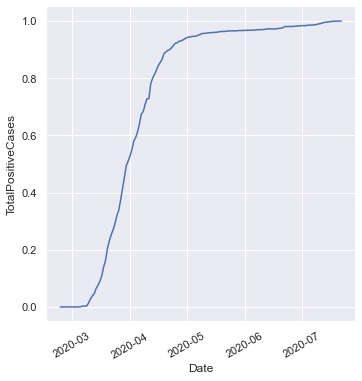

In [8]:
### plotting for P.A. Bolzano
plot = sns.relplot(data= df_for_regions['P.A. Bolzano'], x='Date', y='TotalPositiveCases', kind='line')
plot.set_xticklabels(rotation=30)

In [9]:
train_regions = np.array(['P.A. Bolzano', 'Emilia-Romagna', 'Liguria', 'Lombardia', 'Piemonte', 'P.A. Trento', "Valle d'Aosta", 'Veneto','Friuli Venezia Giulia'])
cv_regions = np.array(['Marche'])
test_regions = np.array(['Lazio', 'Sicilia', 'Campania'])
selected_regions = np.concatenate((train_regions, cv_regions, test_regions))
selected_regions

array(['P.A. Bolzano', 'Emilia-Romagna', 'Liguria', 'Lombardia',
       'Piemonte', 'P.A. Trento', "Valle d'Aosta", 'Veneto',
       'Friuli Venezia Giulia', 'Marche', 'Lazio', 'Sicilia', 'Campania'],
      dtype='<U21')

In [10]:
###create correlation df
corr_df = pandas.DataFrame()
for region in selected_regions:
    corr_df[region] = df_for_regions[region].NewPositiveCases
corr_df.head()

,P.A. Bolzano,Emilia-Romagna,Liguria,Lombardia,Piemonte,P.A. Trento,Valle d'Aosta,Veneto,Friuli Venezia Giulia,Marche,Lazio,Sicilia,Campania
Date,,,,,,,,,,,,,
2020-02-24,0.000000,0.010288,0.000000,0.045778,0.003012,0.0,0.0,0.054608,0.0,0.000000,0.009524,0.000000,0.000000
2020-02-25,0.007092,0.000000,0.003817,0.015466,0.000000,0.0,0.0,0.017065,0.0,0.000000,0.000000,0.017647,0.000000
2020-02-26,0.000000,0.013374,0.038168,0.000000,0.000000,0.0,0.0,0.047782,0.0,0.003731,0.000000,0.000000,0.000000
2020-02-27,0.000000,0.043210,0.030534,0.039282,0.000000,0.0,0.0,0.068259,0.0,0.007463,0.000000,0.005882,0.013333
2020-02-28,0.000000,0.041152,0.000000,0.034024,0.009036,0.0,0.0,0.068259,0.0,0.011194,0.000000,0.000000,0.004444


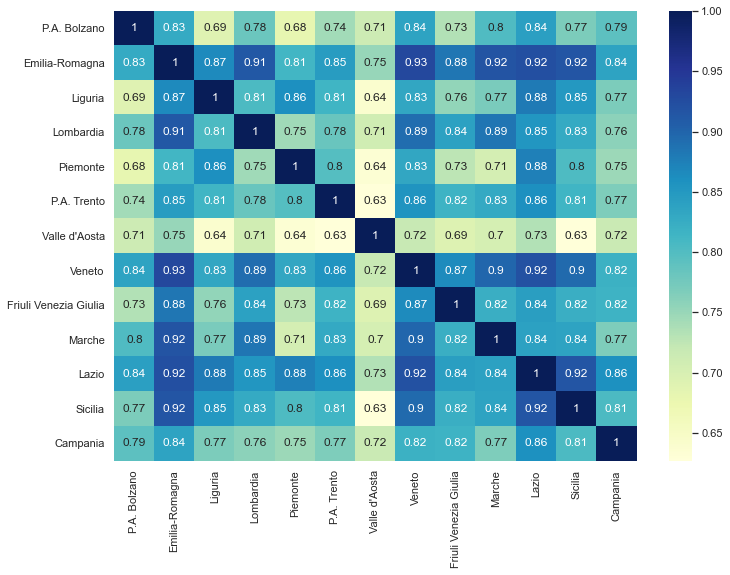

In [11]:
corrMatrix = corr_df.corr()
sns.heatmap(corrMatrix, annot=True, cmap="YlGnBu")
plt.show()

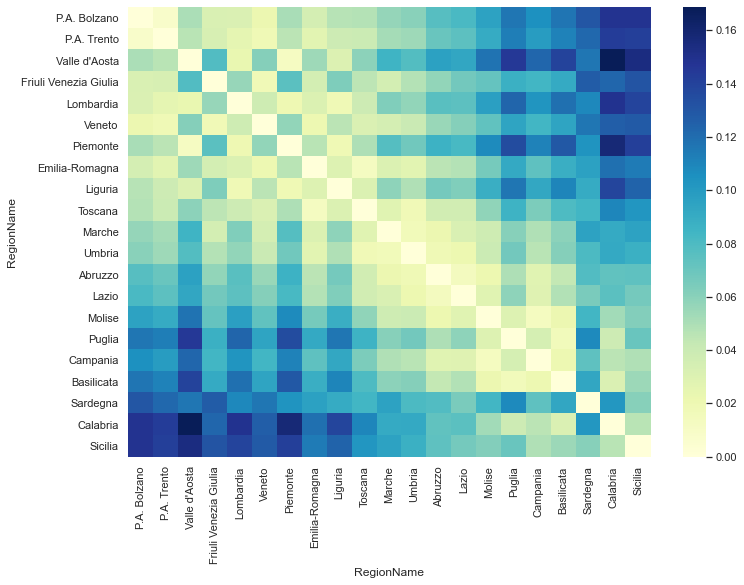

In [12]:
from sklearn.neighbors import DistanceMetric
lat_df['Latitude'] = np.radians(lat_df['Latitude'])
lat_df['Longitude'] = np.radians(lat_df['Longitude'])
dist = DistanceMetric.get_metric('haversine')
dist_matrix = dist.pairwise(lat_df[['Latitude', 'Longitude']]) #[lat_df['RegionName'].isin(selected_regions)]
dist_df = pandas.DataFrame(dist_matrix, columns=lat_df['RegionName'])
dist_df.set_index(lat_df['RegionName'], inplace=True)
sns.heatmap(dist_df, cmap="YlGnBu")
plt.show()

In [13]:
dist_df

RegionName,P.A. Bolzano,P.A. Trento,Valle d'Aosta,Friuli Venezia Giulia,Lombardia,Veneto,Piemonte,Emilia-Romagna,Liguria,Toscana,...,Umbria,Abruzzo,Lazio,Molise,Puglia,Campania,Basilicata,Sardegna,Calabria,Sicilia
RegionName,,,,,,,,,,,,,,,,,,,,,
P.A. Bolzano,0.000000,0.008031,0.050605,0.032748,0.031857,0.022068,0.051189,0.034994,0.046990,0.047665,...,0.060573,0.076734,0.081625,0.095665,0.116612,0.105303,0.116677,0.130322,0.148500,0.148581
P.A. Trento,0.008031,0.000000,0.046522,0.032994,0.025749,0.018498,0.045481,0.027614,0.039496,0.040172,...,0.054043,0.070857,0.074866,0.090446,0.112715,0.099490,0.111815,0.122360,0.143412,0.141796
Valle d'Aosta,0.050605,0.046522,0.000000,0.078602,0.023320,0.061513,0.012406,0.054066,0.030505,0.059652,...,0.078072,0.096430,0.093404,0.117867,0.145177,0.122633,0.139776,0.116135,0.168720,0.154331
Friuli Venezia Giulia,0.032748,0.032994,0.078602,0.000000,0.056026,0.017873,0.075307,0.036065,0.063424,0.045249,...,0.047598,0.057751,0.067532,0.072294,0.088183,0.084172,0.091198,0.127264,0.123202,0.131594
Lombardia,0.031857,0.025749,0.023320,0.056026,0.000000,0.038546,0.019774,0.031518,0.018691,0.039193,...,0.057375,0.075851,0.074945,0.097148,0.123400,0.103269,0.119149,0.109114,0.149130,0.139263
Veneto,0.022068,0.018498,0.061513,0.017873,0.038546,0.000000,0.057566,0.020517,0.045716,0.032032,...,0.040639,0.055446,0.061849,0.073764,0.094666,0.083813,0.094638,0.116242,0.126506,0.128434
Piemonte,0.051189,0.045481,0.012406,0.075307,0.019774,0.057566,0.000000,0.046460,0.019347,0.050035,...,0.068252,0.086339,0.082319,0.107723,0.135721,0.111751,0.129482,0.103897,0.157800,0.142200
Emilia-Romagna,0.034994,0.027614,0.054066,0.036065,0.031518,0.020517,0.046460,0.000000,0.030047,0.012702,...,0.027573,0.045591,0.047673,0.066460,0.091954,0.073898,0.088393,0.096583,0.119099,0.114427
Liguria,0.046990,0.039496,0.030505,0.063424,0.018691,0.045716,0.019347,0.030047,0.000000,0.031204,...,0.049147,0.067082,0.063050,0.088433,0.116647,0.092434,0.110155,0.090720,0.138499,0.124255


In [14]:
closest_regions = {}
for region in regions:
    closest_regions[region] = dist_df.loc[region].sort_values().iloc[1:10].index.values

In [15]:
def create_sequences(values, window_size=7):
    output = []
    for i in range(len(values) - window_size + 1):
        output.append(values[i : (i + window_size)])
    return np.stack(output)

In [16]:
temporal_dataset = {}
for region in regions:
    x = create_sequences(df_for_regions[region].to_numpy())
    temporal_dataset[region] = x

In [17]:
spatio_temporal_dataset = {}
for region in regions:
    result = []
    result.append(temporal_dataset[region])
    neighbours = closest_regions[region]
    for neighbour in neighbours:
        result.append(temporal_dataset[neighbour])
    spatio_temporal_dataset[region] = np.stack(result, axis=3)
    

In [18]:
spatio_temporal_dataset['Abruzzo'].shape

(144, 7, 8, 10)

In [19]:
train_regions

array(['P.A. Bolzano', 'Emilia-Romagna', 'Liguria', 'Lombardia',
       'Piemonte', 'P.A. Trento', "Valle d'Aosta", 'Veneto',
       'Friuli Venezia Giulia'], dtype='<U21')

In [20]:
train_dataset = np.transpose(np.vstack([spatio_temporal_dataset[region] for region in train_regions]), (0,3,1,2))
train_labels = np.vstack([temporal_dataset[region] for region in train_regions])

cv_dataset = np.transpose(np.vstack([spatio_temporal_dataset[region] for region in cv_regions]), (0,3,1,2))
cv_labels = np.vstack([temporal_dataset[region] for region in cv_regions])

test_dataset = np.transpose(np.vstack([spatio_temporal_dataset[region] for region in test_regions]), (0,3,1,2))
test_labels = np.vstack([temporal_dataset[region] for region in test_regions])

In [21]:
print(train_dataset.shape, train_labels.shape)

(1296, 10, 7, 8) (1296, 7, 8)


In [22]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 16 # mini-batch size
num_workers = 4 # how many parallel workers are we gonna use for reading data
shuffle = False

x_train = torch.FloatTensor(train_dataset)
y_train = torch.FloatTensor(train_labels)
tensor_train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(tensor_train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

x_cv = torch.FloatTensor(cv_dataset)
y_cv = torch.FloatTensor(cv_labels)
tensor_cv_dataset = TensorDataset(x_cv, y_cv)
cv_loader = DataLoader(tensor_cv_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

x_test = torch.FloatTensor(test_dataset)
y_test = torch.FloatTensor(test_labels)
tensor_test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(tensor_test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)



In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [24]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [25]:
class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 1, 3, 1, 1),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(),
        )

        

    def forward(self, x):
        z = self.encoder(x)
        return z

In [26]:
class Decoder(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        out, (hn, cn) = self.lstm1(x, (h0,c0))
        out, _ = self.lstm2(out, (hn, cn))
        return out

In [27]:
class AutoEncoder(nn.Module):
    
    def __init__(self, feature_size, output_size, num_lstm_layers=2):
        super(AutoEncoder, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder(feature_size, output_size, num_lstm_layers)

        

    def forward(self, x):
        encoding = self.encoder(x)
        encoding = encoding[:,0,:,:]
        y_pred = self.decoder(encoding)
        return y_pred

In [28]:
def Solver(model, train_loader, optim, criterion, epoch=10, lr=1e-1, print_every=10):
  '''
  The solver function for training your model

  model: your designed model
  train_loader: data loader for training data
  optim: your optimizer
  criterion: criterion for calculating loss, i.e. nn.CrosssEntropyLoss
  epoch: number of training epochs, an epoch means looping through all the data in the datasets
  lr: training learning rate
  print_every: number of epochs to print out loss and accuracies
  '''

  # Send model to GPU for training.
  model.to(device)

  for e in range(epoch):
      loss_epoch = 0
      for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optim.zero_grad()
        y_pred = model(x)
        #if torch.any(y_pred.isnan()): break
        loss =  criterion(y_pred, y)
        #print(loss)
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
      if print_every <= epoch and e % print_every == 0:  
          print(f'Epoch {e}: {loss_epoch}')
  return model

In [29]:
#torch.manual_seed(0)
epoch = 100
lr = 1e-4
feature_size = x_train.shape[3]
output_size = x_train.shape[3]
num_lstm_layers = 2
batch_size = 16

################################################################################
                                                       #
model = AutoEncoder(feature_size, output_size, num_lstm_layers)
model.apply(initialize_parameters)
optim = torch.optim.Adam(model.parameters())
#optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.L1Loss()
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################
model = Solver(model, train_loader, optim, criterion, epoch=epoch, lr=lr, print_every=1)
torch.save(model, 'my-model.pth')

Epoch 0: 35.36240481585264
Epoch 1: 21.804091691970825
Epoch 2: 14.206587336957455
Epoch 3: 11.444301687180996
Epoch 4: 9.529230538755655
Epoch 5: 7.883441625162959
Epoch 6: 6.715305706486106
Epoch 7: 6.107091445475817
Epoch 8: 5.680361380800605
Epoch 9: 5.429886564612389
Epoch 10: 4.947426736354828
Epoch 11: 5.096979711204767
Epoch 12: 4.4335288451984525
Epoch 13: 4.389932334423065
Epoch 14: 4.230340286158025
Epoch 15: 4.174509653821588
Epoch 16: 4.024583616293967
Epoch 17: 3.9999215081334114
Epoch 18: 3.8797085005789995
Epoch 19: 3.843493979424238
Epoch 20: 3.738720105960965
Epoch 21: 3.7528853751719
Epoch 22: 3.5980717558413744
Epoch 23: 3.7134765638038516
Epoch 24: 3.6675986368209124
Epoch 25: 3.596561398357153
Epoch 26: 3.643581425771117
Epoch 27: 3.469382781535387
Epoch 28: 3.482132215052843
Epoch 29: 3.710059189237654
Epoch 30: 3.4949522307142615
Epoch 31: 3.5654580565169454
Epoch 32: 3.5030046943575144
Epoch 33: 3.5117350770160556
Epoch 34: 3.67292498704046
Epoch 35: 3.43935450

In [30]:
def predict(x):
    x = x.to(device)
    y_pred = model(x)
    return y_pred

In [31]:
print(x_train.shape)
x_train_pred = predict(x_train).detach().numpy()
x_train_pred.shape

torch.Size([1296, 10, 7, 8])


(1296, 7, 8)

In [32]:
train_labels = y_train.detach().numpy()
reconstructed_cases = x_train_pred[:,0, 4]
actual_cases = train_labels[:,0, 4]
cases_train_mae_loss = np.abs(reconstructed_cases - actual_cases)


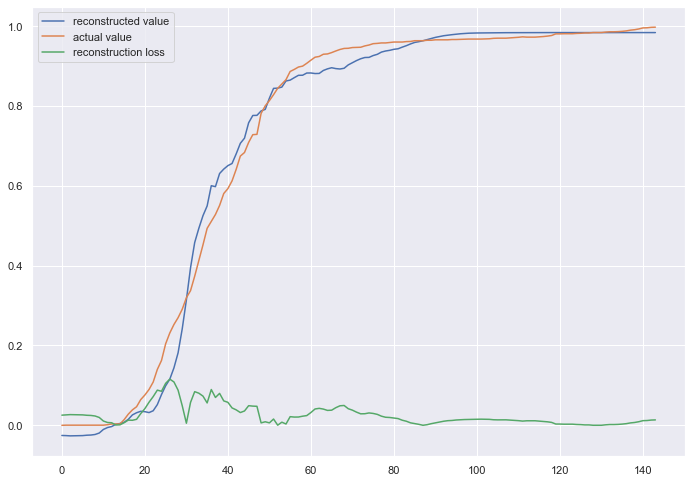

In [33]:
plt.plot(reconstructed_cases[0:144], label="reconstructed value")
plt.plot(actual_cases[0:144], label="actual value")
plt.plot(cases_train_mae_loss[0:144], label="reconstruction loss")
plt.legend(loc="upper left")
plt.show()

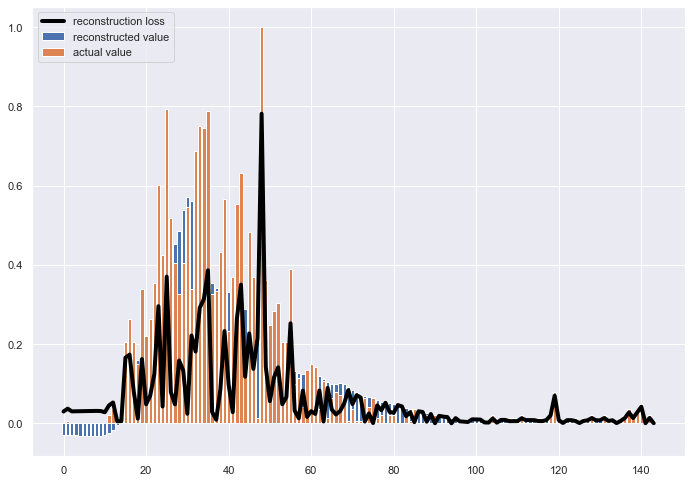

In [34]:
reconstructed_daily_cases = x_train_pred[:,0, 2]
actual_daily_cases = train_labels[:,0, 2]
daily_cases_train_mae_loss = np.abs(reconstructed_daily_cases - actual_daily_cases)
plt.bar(range(0,144),reconstructed_daily_cases[0:144], label="reconstructed value")
plt.bar(range(0,144),actual_daily_cases[0:144], label="actual value")
plt.plot(daily_cases_train_mae_loss[0:144], color='black', linewidth=4, label="reconstruction loss")
plt.legend(loc="upper left")
plt.show()

In [35]:
print(x_test[0:144].shape)
x_test_pred = predict(x_test[0:144]).detach().numpy()
x_test_pred.shape

torch.Size([144, 10, 7, 8])


(144, 7, 8)

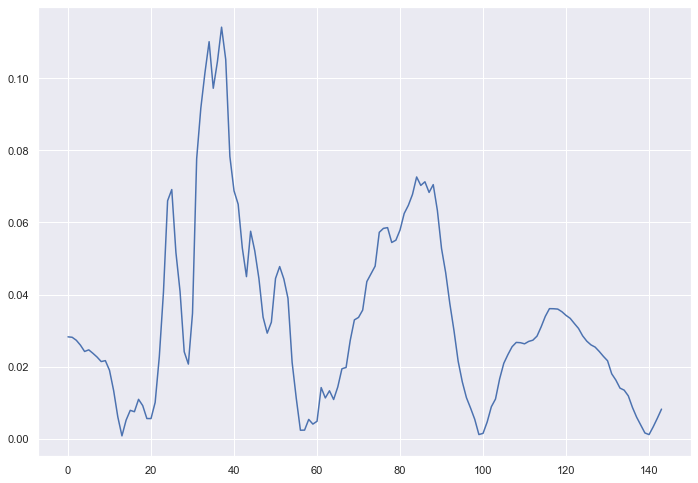

In [36]:
test_labels = y_test[0:144].detach().numpy()
reconstructed_cases = x_test_pred[:,0, 4]
actual_cases = test_labels[:,0, 4]
test_mae_loss = np.abs(reconstructed_cases - actual_cases)
plt.plot(test_mae_loss)

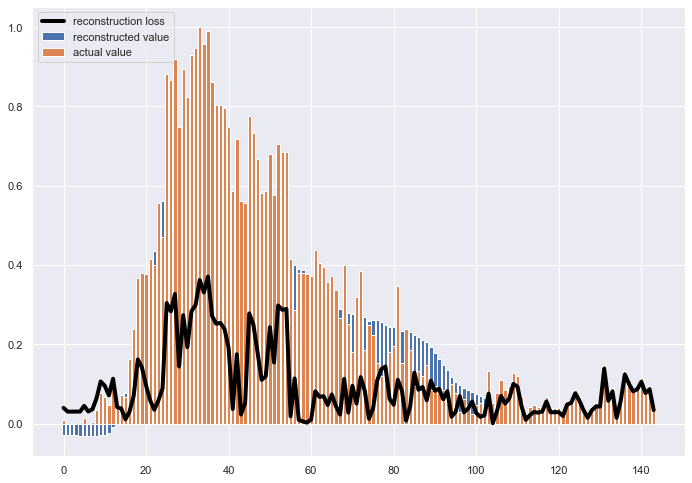

In [37]:
reconstructed_daily_cases = x_test_pred[:,0, 2]
actual_daily_cases = test_labels[:,0, 2][0:144]
daily_cases_test_mae_loss = np.abs(reconstructed_daily_cases - actual_daily_cases)
plt.bar(range(0,144),reconstructed_daily_cases[0:144], label="reconstructed value")
plt.bar(range(0,144),actual_daily_cases[0:144], label="actual value")
plt.plot(daily_cases_test_mae_loss[0:144], color='black', linewidth=4, label="reconstruction loss")
plt.legend(loc="upper left")
plt.show()

In [38]:
x_train_pred.shape

(1296, 7, 8)

In [39]:
def reconstruct_data(subseq_data):
    output = []
    for time_stamp in subseq_data:
        if np.all(time_stamp == subseq_data[-1]) :
            for seq in time_stamp:
                output.append(seq)
        else:
            obs = time_stamp[1,:]
            output.append(obs)
    return np.stack(output)
            



In [40]:
len(x_train_pred)
rec = reconstruct_data(x_train_pred[0:144])
reconstructed_train_df = pandas.DataFrame(rec, columns=df_for_regions['Abruzzo'].columns, index = df_for_regions['Abruzzo'].index)
reconstructed_train_df

,IntensiveCarePatients,TotalHospitalizedPatients,NewPositiveCases,Deaths,TotalPositiveCases,NewPositiveCaseDensity,DeathDensity,TotalPositiveCaseDensity
Date,,,,,,,,
2020-02-24,-0.021185,0.002518,-0.000863,0.027726,-0.006293,-0.034461,0.032240,0.041961
2020-02-25,-0.021425,0.002760,-0.001057,0.026652,-0.006783,-0.034424,0.031673,0.040751
2020-02-26,-0.022260,0.002902,-0.001436,0.024725,-0.007613,-0.034783,0.031057,0.039772
2020-02-27,-0.022744,0.002606,-0.001777,0.022859,-0.007891,-0.035128,0.029949,0.038113
2020-02-28,-0.022991,0.002698,-0.002027,0.021484,-0.007885,-0.034925,0.028809,0.036247
...,...,...,...,...,...,...,...,...
2020-07-18,0.006334,0.019508,0.006923,0.992230,0.987125,0.008763,0.992934,0.987441
2020-07-19,0.006141,0.018722,0.006629,0.992550,0.987673,0.008268,0.993194,0.987777
2020-07-20,0.006086,0.018551,0.006524,0.992706,0.987928,0.008018,0.993298,0.987887


In [41]:
df_for_regions['P.A. Bolzano']

,IntensiveCarePatients,TotalHospitalizedPatients,NewPositiveCases,Deaths,TotalPositiveCases,NewPositiveCaseDensity,DeathDensity,TotalPositiveCaseDensity
Date,,,,,,,,
2020-02-24,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2020-02-25,0.0,0.002571,0.007092,0.0,0.000372,0.007092,0.0,0.000372
2020-02-26,0.0,0.002571,0.000000,0.0,0.000372,0.000000,0.0,0.000372
2020-02-27,0.0,0.002571,0.000000,0.0,0.000372,0.000000,0.0,0.000372
2020-02-28,0.0,0.002571,0.000000,0.0,0.000372,0.000000,0.0,0.000372
...,...,...,...,...,...,...,...,...
2020-07-18,0.0,0.015424,0.007092,1.0,0.999255,0.007092,1.0,0.999255
2020-07-19,0.0,0.015424,0.007092,1.0,0.999628,0.007092,1.0,0.999628
2020-07-20,0.0,0.015424,0.000000,1.0,0.999628,0.000000,1.0,0.999628
